In [1]:
import os
import sys
sys.path.append(os.getcwd())

from lib.models.model_execution_support import run_on_inputs_with_targets
from lib.models.recurrent_forecaster_with_correction_block import RecurrentForecasterWithCorrectionBlock
from lib.models.recurrent_sigmoid_piecewise_forecaster import RSPForecaster
from lib.models.linear_forecaster import LinearForecaster
from lib.utils.recurrent_contexts_manager import RecurrentContextsManager

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import pandas as pd
import pandas_datareader.data as web

from typing import Any
from typing import Optional
from typing import Tuple
from uuid import uuid4
import datetime
import time

In [2]:
DEVICE = 'cpu'
DTYPE = torch.float32

# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

torch.set_printoptions(precision=10)

In [3]:
df = pd.read_csv('heart_rate.csv')
print(df['T4'][890])
heart_data = np.array(df[:891]).transpose(1, 0)
heart_data = heart_data / (heart_data.max() - heart_data.min())
heart_data = heart_data - heart_data.mean()
print(heart_data)
print(heart_data.shape)

62.0
[[ 0.14598108  0.14598108  0.14204635 ...  0.4683017   0.45550151
   0.43827048]
 [ 0.28219521  0.28219521  0.27689336 ...  0.40076932  0.38879281
   0.38256881]
 [-0.30440775 -0.30440775 -0.30484894 ... -0.36155229 -0.35393276
  -0.34546305]
 [-0.32704289 -0.32704289 -0.32704289 ... -0.29516359 -0.26901976
  -0.2757001 ]]
(4, 891)


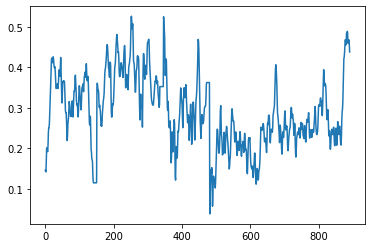

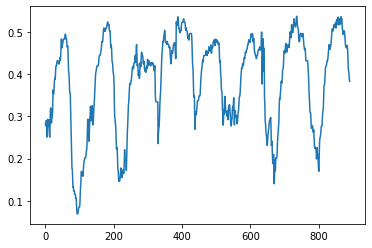

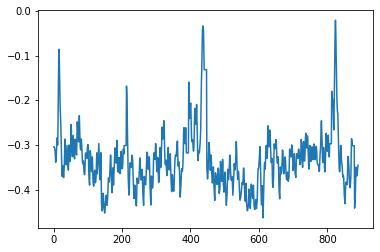

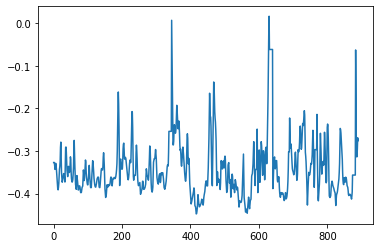

In [4]:
plt.figure()
plt.plot(range(heart_data.shape[1]), heart_data[0, :])
plt.figure()
plt.plot(range(heart_data.shape[1]), heart_data[1, :])
plt.figure()
plt.plot(range(heart_data.shape[1]), heart_data[2, :])
plt.figure()
plt.plot(range(heart_data.shape[1]), heart_data[3, :])

In [5]:
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2021, 1, 27)

f = web.DataReader('^DJI', 'stooq', start, end)
ts = np.flip(f['Open'].values, axis=0).copy()
ts = ts / (ts.max() - ts.min())
ts = ts - ts.mean()

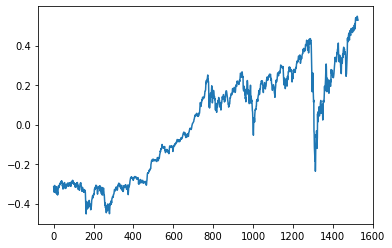

In [6]:
plt.figure()
plt.plot(range(len(ts)), ts)
plt.show()

In [7]:
print(type(ts))
print(ts.shape)
print(ts.strides)

<class 'numpy.ndarray'>
(1528,)
(8,)


In [9]:
INP_SIZE = 2

def sw(t: torch.Tensor) -> torch.Tensor:
    return t.unfold(dimension=1, size=INP_SIZE, step=1)

def get_train_test_data_heart_rate(heart_data, train_ratio=0.9):
    N = heart_data.shape[1]
    train_size = int(N * train_ratio)
    test_size = N - train_size
    train_ts = heart_data[:, :train_size]
    test_ts = heart_data[:, train_size:]
    return (
        sw(torch.from_numpy(train_ts[:, :-1])).permute(1, 0, 2).to(DEVICE, dtype=DTYPE),
        torch.from_numpy(train_ts[:, INP_SIZE:]).permute(1, 0).unsqueeze(-1).to(DEVICE, dtype=DTYPE),
        sw(torch.from_numpy(test_ts[:, :-1])).permute(1, 0, 2).to(DEVICE, dtype=DTYPE),
        torch.from_numpy(test_ts[:, INP_SIZE:]).permute(1, 0).unsqueeze(-1).to(DEVICE, dtype=DTYPE),
    )


def get_train_test_data_from_ts(ts: np.ndarray, train_ratio=0.9):
    N = len(ts)
    train_size = int(N * train_ratio)
    test_size = N - train_size
    train_ts = ts[:train_size]
    test_ts = ts[train_size:]
    return (
        sw(torch.from_numpy(train_ts[:-1]).view(1, train_size - 1)).permute(1, 0, 2).to(DEVICE, dtype=DTYPE),
        torch.from_numpy(train_ts[INP_SIZE:])[:, None, None].to(DEVICE, dtype=DTYPE),
        sw(torch.from_numpy(test_ts[:-1]).view(1, test_size - 1)).permute(1, 0, 2).to(DEVICE, dtype=DTYPE),
        torch.from_numpy(test_ts[INP_SIZE:])[:, None, None].to(DEVICE, dtype=DTYPE)
    )


inp, target, test_input, test_target = get_train_test_data_heart_rate(heart_data, train_ratio=0.8)

print(inp.shape, target.shape, test_input.shape, test_target.shape)

torch.Size([710, 4, 2]) torch.Size([710, 4, 1]) torch.Size([177, 4, 2]) torch.Size([177, 4, 1])


In [19]:
cm = RecurrentContextsManager()
baseline = LinearForecaster.find_optimal_least_squares_forecaster(cm, inp, target, bias=True)
print(baseline.predictor.weight.data)
print(baseline.predictor.bias.data)

tensor([[-0.2942165434,  1.2916926146]])
tensor([4.1599028918e-05])


torch.Size([710, 4, 1]) torch.Size([710, 4, 1])
tensor(0.0004731049, grad_fn=<MeanBackward0>)


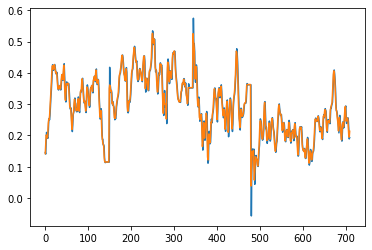

In [11]:
baseline_forecasts = run_on_inputs_with_targets(baseline, inp, target, setup_ctxs=False, delete_ctxs=False)
print(baseline_forecasts.shape, target.shape)
print(torch.square(baseline_forecasts - target).mean())
N, S, one = target.shape
SEQ_IDX = 0
plt.figure()
plt.plot(np.arange(N), baseline_forecasts[:, SEQ_IDX, :].detach())
plt.plot(np.arange(N), target[:, SEQ_IDX, :].detach())
plt.show()

torch.Size([177, 4, 1]) torch.Size([177, 4, 1])
tensor(0.0004800508, grad_fn=<MeanBackward0>)


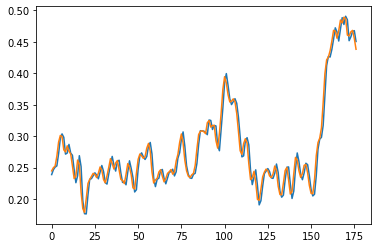

In [12]:
baseline_forecasts = run_on_inputs_with_targets(baseline, test_input, test_target,
                                                setup_ctxs=False, delete_ctxs=False)
print(baseline_forecasts.shape, test_target.shape)
print(torch.square(baseline_forecasts - test_target).mean())
N, S, one = test_target.shape
SEQ_IDX = 0
plt.figure()
plt.plot(np.arange(N), baseline_forecasts[:, SEQ_IDX, :].detach())
plt.plot(np.arange(N), test_target[:, SEQ_IDX, :].detach())
plt.show()

In [23]:
HIDDEN_SIZE = 8
LR = 0.08
STEPS = 50
PREV_ERRORS_NO_GRAD = True
USE_PREV_ERRORS = True

start = time.perf_counter_ns()

# INP_SIZE + 1 because correction block also takes baseline
# forecast as extra input
corrector = RSPForecaster(cm, INP_SIZE + 1, HIDDEN_SIZE, use_prev_errors=USE_PREV_ERRORS)
model = RecurrentForecasterWithCorrectionBlock(cm, baseline, corrector)

criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(model.parameters(), lr=LR)

test_losses = []
#begin to train
for i in range(STEPS):
    print('STEP: ', i)
    if isinstance(optimizer, optim.LBFGS):
        def closure():
            optimizer.zero_grad()
            baseline_no_grad = i < 15
            out = run_on_inputs_with_targets(model, inp, target, baseline_no_grad=baseline_no_grad,
                                            prev_errors_no_grad=PREV_ERRORS_NO_GRAD)
            loss = criterion(out, target)
            print('loss:', loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)
    else:
        optimizer.zero_grad()
        out = run_on_inputs_with_targets(model, inp, target, baseline_no_grad=True)
        loss = criterion(out, target)
        print('loss: ', loss.item())
        loss.backward()
        optimizer.step()
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        pred = run_on_inputs_with_targets(model, test_input, test_target, baseline_no_grad=True)
        loss = criterion(pred, test_target)
        print('test loss:', loss.item())
        test_losses.append(loss.item())
    
end = time.perf_counter_ns()
print(f'Elapsed time: {(end - start)/1_000_000_000} seconds.')
print(f'Min test loss: {min(test_losses)}')

STEP:  0
loss: 0.04633227735757828
loss: 0.0348527617752552
loss: 0.02963622659444809
loss: 0.025069881230592728
loss: 0.02110975980758667
loss: 0.017697475850582123
loss: 0.014776159077882767
loss: 0.012293624691665173
loss: 0.01020183227956295
loss: 0.008455492556095123
loss: 0.007010648027062416
loss: 0.005824618972837925
loss: 0.0048568230122327805
loss: 0.0040700603276491165
loss: 0.003431494114920497
loss: 0.0029130808543413877
loss: 0.0024915130343288183
loss: 0.0021477886475622654
loss: 0.0018666223622858524
loss: 0.0016357986023649573
test loss: 0.0015278338687494397
STEP:  1
loss: 0.0014456042554229498
loss: 0.0012883151648566127
loss: 0.001157785882242024
loss: 0.0010491118300706148
loss: 0.0009583673090673983
loss: 0.0008823926327750087
loss: 0.0008186387130990624
loss: 0.0007650328916497529
loss: 0.0007198855164460838
loss: 0.0006818117690272629
loss: 0.0006496699061244726
loss: 0.0006225139368325472
loss: 0.0005995588726364076
loss: 0.0005801483057439327
loss: 0.000563732

loss: 0.0004592581244651228
loss: 0.0004591778269968927
loss: 0.00045910337939858437
loss: 0.000459037022665143
loss: 0.000458975147921592
loss: 0.00045892110210843384
loss: 0.0004588768642861396
loss: 0.00045883553684689105
loss: 0.00045879912795498967
test loss: 0.0004601726832333952
STEP:  14
loss: 0.0004587673756759614
loss: 0.00045874033821746707
loss: 0.00045871592010371387
loss: 0.0004586939176078886
loss: 0.0004586733120959252
loss: 0.0004586538707371801
loss: 0.000458635448012501
loss: 0.0004586179566103965
loss: 0.0004586008144542575
loss: 0.00045858370140194893
loss: 0.0004585661517921835
loss: 0.00045854755444452167
loss: 0.0004585269489325583
loss: 0.00045850244350731373
loss: 0.0004584690323099494
loss: 0.00045843690168112516
loss: 0.0004584034613799304
loss: 0.0004583460686262697
loss: 0.0004582835827022791
loss: 0.00045821850653737783
test loss: 0.0004607261798810214
STEP:  15
loss: 0.0004581444663926959
loss: 0.00045801070518791676
loss: 0.0004579382366500795
loss: 0.0

loss: 0.0004508467100095004
loss: 0.0004508423444349319
loss: 0.0004508379497565329
loss: 0.0004508330312091857
loss: 0.0004508281999733299
loss: 0.00045082293218001723
loss: 0.00045081746065989137
loss: 0.00045081155258230865
loss: 0.00045080529525876045
loss: 0.0004507990088313818
loss: 0.00045079190749675035
loss: 0.000450785068096593
loss: 0.00045077732647769153
loss: 0.00045077031245455146
loss: 0.0004507623962126672
loss: 0.0004507545963861048
loss: 0.000450746068963781
loss: 0.00045073736691847444
loss: 0.00045072814100421965
loss: 0.0004507186822593212
test loss: 0.0004634324286598712
STEP:  28
loss: 0.00045070890337228775
loss: 0.00045069874613545835
loss: 0.0004506882687564939
loss: 0.00045067715109325945
loss: 0.0004506656841840595
loss: 0.00045065366430208087
loss: 0.00045064103323966265
loss: 0.0004506277327891439
loss: 0.0004506129480432719
loss: 0.0004505978140514344
loss: 0.00045058198156766593
loss: 0.0004505691467784345
loss: 0.0004505553806666285
loss: 0.000450541469

loss: 0.00044709976646117866
loss: 0.00044709170470014215
loss: 0.00044708370114676654
loss: 0.0004470747953746468
loss: 0.00044706615153700113
loss: 0.0004470578278414905
loss: 0.0004470491549000144
loss: 0.0004470407438930124
loss: 0.00044703163439407945
loss: 0.00044702275772579014
loss: 0.0004470132989808917
test loss: 0.0004638428508769721
STEP:  41
loss: 0.00044700418948195875
loss: 0.0004469944688025862
loss: 0.0004469850391615182
loss: 0.0004469753475859761
loss: 0.0004469660925678909
loss: 0.00044695442193187773
loss: 0.0004469444102142006
loss: 0.0004469348059501499
loss: 0.0004469247651286423
loss: 0.00044691446237266064
loss: 0.0004469031991902739
loss: 0.0004468904808163643
loss: 0.0004468772967811674
loss: 0.0004468638217076659
loss: 0.00044684947351925075
loss: 0.0004468357947189361
loss: 0.0004468221450224519
loss: 0.0004468091647140682
loss: 0.0004467967664822936
loss: 0.00044678570702672005
test loss: 0.00046393839875236154
STEP:  42
loss: 0.0004467754333745688
loss: 

In [22]:
print(baseline.predictor.weight.data)
print(baseline.predictor.bias.data)

tensor([[-0.2942165434,  1.2916926146]])
tensor([4.1599028918e-05])


torch.Size([799, 4, 1]) torch.Size([799, 4, 1])
tensor(0.0004283167)


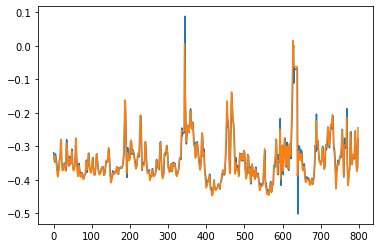

In [38]:
with torch.no_grad():
    model_forecasts = run_on_inputs_with_targets(model, inp, target, setup_ctxs=True, delete_ctxs=True)
    print(model_forecasts.shape, target.shape)
    print(torch.square(model_forecasts - target).mean())
    N, S, one = target.shape
    SEQ_IDX = 3
    plt.figure()
    plt.plot(np.arange(N), model_forecasts[:, SEQ_IDX, :].detach())
    plt.plot(np.arange(N), target[:, SEQ_IDX, :].detach())
    plt.show()

torch.Size([88, 4, 1]) torch.Size([88, 4, 1])
tensor(0.0006804501)


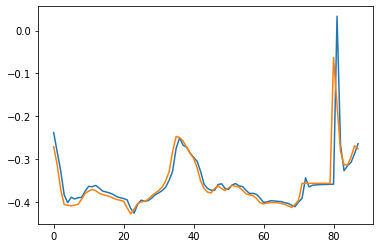

In [39]:
with torch.no_grad():
    model_forecasts = run_on_inputs_with_targets(model, test_input, test_target,
                                                 setup_ctxs=True, delete_ctxs=True)
    print(model_forecasts.shape, test_target.shape)
    print(torch.square(model_forecasts - test_target).mean())
    N, S, one = test_target.shape
    SEQ_IDX = 3
    plt.figure()
    plt.plot(np.arange(N), model_forecasts[:, SEQ_IDX, :].detach())
    plt.plot(np.arange(N), test_target[:, SEQ_IDX, :].detach())
    plt.show()

In [16]:
print('''
loss: 0.00044439133489504457
test loss: 0.0004625237488653511
Elapsed time: 263.367878655 seconds.
Min test loss: 0.00046113631105981767
''')


loss: 0.00044439133489504457
test loss: 0.0004625237488653511
Elapsed time: 263.367878655 seconds.
Min test loss: 0.00046113631105981767



In [14]:
print(test_target.shape)

torch.Size([4, 88])


In [44]:
'RSP test loss: 0.0006836527948247121'

'RSP test loss: 0.0006836527948247121'

In [46]:
'Linear test loss: 0.00068016676907737'

'Linear test loss: 0.00068016676907737'